# Projet Python

## Description des données

Nous avons récupéré les données du sites IMDB. Nous avons donc les scores IMDB pour 5000 films ainsi que d'autres données sur le film (durée, nombre de "like" FaceBook des acteurs, budget...).

In [49]:
# Start pylab inline mode, so figures will appear in the notebook
%matplotlib inline
# Import packages
import pandas
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

#os.chdir('/Users/marionkarakouzian/Documents/ENSAE/2A/S1/Projet Python')

# Import data frame en csv avec pandas et petit aperçu 
data = pandas.read_csv("movie_metadata.csv")
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

In [50]:
#Nettoyage du dataframe

#Suppression des variables qualitatives non utilisées dans la modélisation
del data['movie_title']
del data['director_name']
del data['actor_3_name']
del data['actor_2_name']
del data['actor_1_name']
del data['plot_keywords']
del data['movie_imdb_link']

#Suppression des lignes avec des valeurs manquantes
data=data.dropna()

#Affichage des modalités de la variable Color pour la recoder
print(data.color.unique().tolist())


['Color', ' Black and White']


In [56]:
len(data.index)

3770

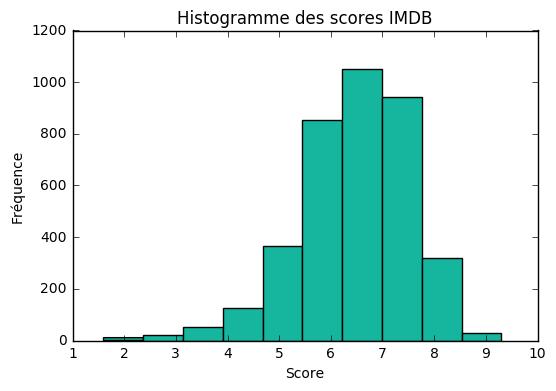

In [51]:
#Histogramme des scores
plt.hist(data.imdb_score, facecolor='#16b69e')
plt.title("Histogramme des scores IMDB")
plt.xlabel("Score")
plt.ylabel("Fréquence")

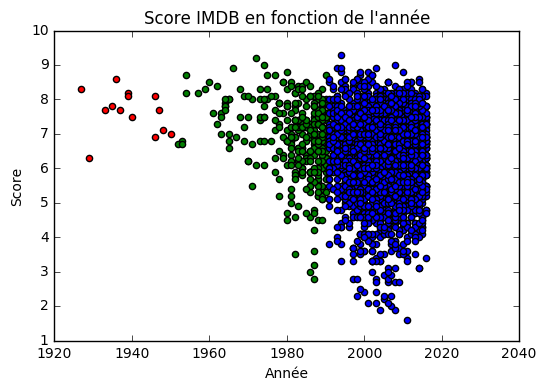

In [52]:
#Graph pour visualiser l'effet de l'année sur la note
plt.scatter(data.title_year[data.title_year<=1950],data.imdb_score[data.title_year<=1950],c='red')
plt.scatter(data.title_year[(data.title_year>1950) & (data.title_year<=1990)],data.imdb_score[(data.title_year>1950) & (data.title_year<=1990)],c='green')
plt.scatter(data.title_year[data.title_year>1990],data.imdb_score[data.title_year>1990],c='blue')
plt.title("Score IMDB en fonction de l'année")
plt.xlabel("Année")
plt.ylabel("Score")

On peut voir que les années n'ont pas d'influence évidente et visible d'après ce graphique sur le score IMDB. En revanche, on peut voir que les films sortis avant les années 50 sont très peu nombreux et les films récents (après 1990) sont très nombreux.
Revoir nos classes pour les équilibrer??

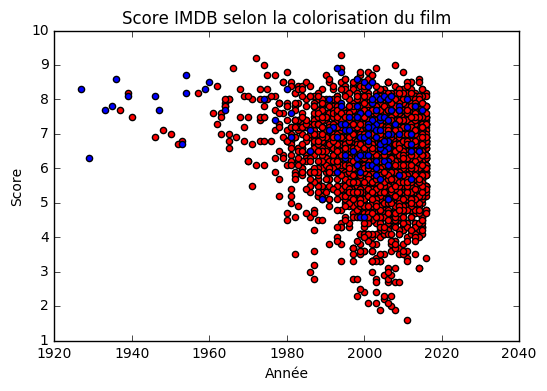

In [53]:
#Graph pour visualiser l'effet de couleur ou pas couleur sur le score IMDB

plt.scatter(data.title_year[data.color=='Color'],data.imdb_score[data.color=='Color'],c='red')
plt.scatter(data.title_year[data.color==' Black and White'],data.imdb_score[data.color==' Black and White'],c='blue')
plt.title("Score IMDB selon la colorisation du film")
plt.xlabel("Année")
plt.ylabel("Score")

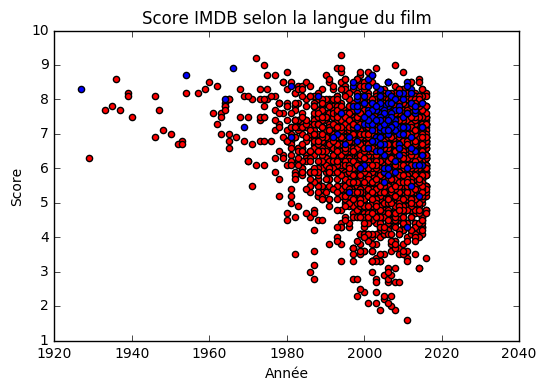

In [58]:
#Graph pour visualiser l'effet de anglais ou pas anglais sur le score IMDB

plt.scatter(data.title_year[data.language=='English'],data.imdb_score[data.language=='English'],c='red')
plt.scatter(data.title_year[data.language!='English'],data.imdb_score[data.language!='English'],c='blue')
plt.title("Score IMDB selon la langue du film")
plt.xlabel("Année")
plt.ylabel("Score")

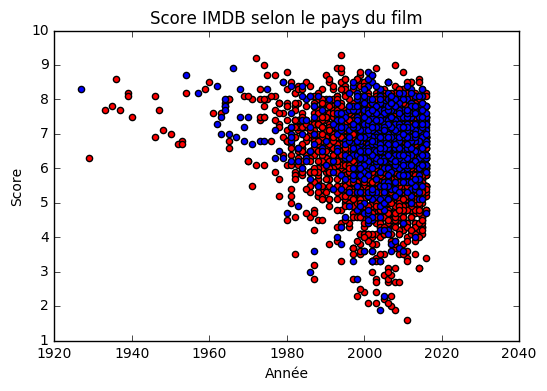

In [59]:
#Graph pour visualiser l'effet de anglais ou pas anglais sur le score IMDB

plt.scatter(data.title_year[data.country=='USA'],data.imdb_score[data.country=='USA'],c='red')
plt.scatter(data.title_year[data.country!='USA'],data.imdb_score[data.country!='USA'],c='blue')
plt.title("Score IMDB selon le pays du film")
plt.xlabel("Année")
plt.ylabel("Score")

In [40]:
#Recodage de la variable Color en indicatrice
data.loc[data['color']=='Color','ColorNum']=1
data.loc[data['color']==' Black and White','ColorNum']=0
del data['color']

data.head(10)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,genres,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,ColorNum
0,723.0,178.0,0.0,855.0,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,886204,4834,0.0,...,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,1.0
1,302.0,169.0,563.0,1000.0,40000.0,309404152.0,Action|Adventure|Fantasy,471220,48350,0.0,...,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,1.0
2,602.0,148.0,0.0,161.0,11000.0,200074175.0,Action|Adventure|Thriller,275868,11700,1.0,...,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000,1.0
3,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,Action|Thriller,1144337,106759,0.0,...,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,1.0
5,462.0,132.0,475.0,530.0,640.0,73058679.0,Action|Adventure|Sci-Fi,212204,1873,1.0,...,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000,1.0
6,392.0,156.0,0.0,4000.0,24000.0,336530303.0,Action|Adventure|Romance,383056,46055,0.0,...,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0,1.0
7,324.0,100.0,15.0,284.0,799.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,294810,2036,1.0,...,English,USA,PG,260000000.0,2010.0,553.0,7.8,1.85,29000,1.0
8,635.0,141.0,0.0,19000.0,26000.0,458991599.0,Action|Adventure|Sci-Fi,462669,92000,4.0,...,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000,1.0
9,375.0,153.0,282.0,10000.0,25000.0,301956980.0,Adventure|Family|Fantasy|Mystery,321795,58753,3.0,...,English,UK,PG,250000000.0,2009.0,11000.0,7.5,2.35,10000,1.0
10,673.0,183.0,0.0,2000.0,15000.0,330249062.0,Action|Adventure|Sci-Fi,371639,24450,0.0,...,English,USA,PG-13,250000000.0,2016.0,4000.0,6.9,2.35,197000,1.0


In [41]:
#Faire 3 catégories avec les années
data.loc[data['title_year']<=1950,'Year']=3
data.loc[(data['title_year']>1950) & (data['title_year']<=1990),'Year']=2
data.loc[data['title_year']>1990,'Year']=1
del data['title_year']

In [73]:
#Calculer un score à partir du genre du film
genre="Action"
data.genres.apply(str)
print(type(data['genres']))
nb=genre.count(data['genres'])
print(nb)

<class 'pandas.core.series.Series'>


TypeError: Can't convert 'Series' object to str implicitly

In [42]:
scores=data['imdb_score']
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores (scores)

#https://www.kaggle.com/mihailburduja/d/deepmatrix/imdb-5000-movie-dataset/predicting-imdb-score-from-selected-fields
#Ce lien est pas mal y'a pleins de trucs. Et chez lui y'a model selection...je comprends paaaas

Scores: 0       7.9
1       7.1
2       6.8
3       8.5
5       6.6
6       6.2
7       7.8
8       7.5
9       7.5
10      6.9
11      6.1
12      6.7
13      7.3
14      6.5
15      7.2
16      6.6
17      8.1
18      6.7
19      6.8
20      7.5
21      7.0
22      6.7
23      7.9
24      6.1
25      7.2
26      7.7
27      8.2
28      5.9
29      7.0
30      7.8
       ... 
4931    7.9
4933    7.4
4936    7.5
4941    7.5
4955    6.7
4956    4.2
4959    7.0
4962    7.0
4964    6.8
4971    6.6
4973    7.5
4975    5.3
4977    7.3
4978    5.6
4979    5.6
4984    6.6
4987    6.3
4997    7.5
4998    7.6
5004    4.1
5008    7.8
5011    7.3
5012    5.7
5015    7.1
5025    6.1
5026    6.9
5027    7.5
5033    7.0
5035    6.9
5042    6.6
Name: imdb_score, dtype: float64
Mean: 6.463872679045076
Standard deviation: 1.0573046849602612


## 1ère prédiction grâce à une régression inéaire

Model coefficient: 3.07955, and intercept: 6955.90172


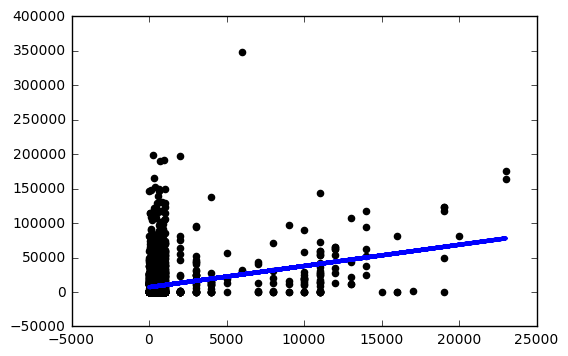

In [43]:
#Test d'une première régression simple

#Pour x: actor_3_facebook_likes
X=data.iloc[1:5042, [3]].values
y=data.iloc[1:5042, 18].values

modelReg = LinearRegression(normalize=True)
modelReg.fit(X,y)

print("Model coefficient: %.5f, and intercept: %.5f"
      % (modelReg.coef_, modelReg.intercept_))

plt.scatter(X, y,  color='black')
plt.plot(X, modelReg.predict(X), color='blue',
         linewidth=3)

plt.show()

#WOUHOU CA MARCHE !!
#problème d'échelle !!

In [44]:
#Truc intéressant à tester: visiblement en utilisant ça je peux faire une régression multiple après sur data
#J'ai supprimé avant language, country, content_rating et genres

del data['language']
del data['country']
del data['content_rating']
del data['genres']

scores = data['imdb_score'].copy(deep=True)

# Scaling inputs
for x in data:
    m = data[x].max() * 1.0
    data[x] = data[x].apply(lambda x: x / m)
    
del data['imdb_score']
data.head()


,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,actor_2_facebook_likes,aspect_ratio,movie_facebook_likes,ColorNum,Year
0,0.889299,0.539394,0.000000,0.037174,0.001563,1.000000,0.524454,0.007361,0.000000,0.603557,0.019402,0.006832,0.111250,0.094556,1.0,0.333333
1,0.371464,0.512121,0.024478,0.043478,0.062500,0.406840,0.278867,0.073622,0.000000,0.244664,0.024559,0.036496,0.146875,0.000000,1.0,0.333333
2,0.740467,0.448485,0.000000,0.007000,0.017188,0.263080,0.163258,0.017816,0.023256,0.196443,0.020056,0.002869,0.146875,0.243553,1.0,0.333333
3,1.000000,0.496970,0.956522,1.000000,0.042188,0.589253,0.677217,0.162561,0.000000,0.533794,0.020466,0.167883,0.146875,0.469914,1.0,0.333333
5,0.568266,0.400000,0.020652,0.023043,0.001000,0.096066,0.125582,0.002852,0.023256,0.145850,0.021587,0.004613,0.146875,0.068768,1.0,0.333333


In [45]:
lin_reg = LinearRegression()
lin_reg.fit(data, scores)

#Afficher les coefficients de la régression linéaire
print('Coefficients: \n',lin_reg.coef_)
print("Mean squared error: %.2f"
      % np.mean((lin_reg.predict(data) - scores) ** 2))

print('Variance score: %.2f' % lin_reg.score(data, scores))

data1=data.values
scores1=scores.values

data = sm.add_constant(data)
linReg = sm.OLS(scores, data).fit()
linReg.summary()


#Problème: je sais pas comment afficher les résultats du modèle.. :(


Coefficients: 
 [  1.49697543   3.77095327   0.08059087   1.63482402  45.95253654
  -1.3899235    6.61112041 -46.47703457  -1.30890941  -2.91742311
  -0.48557601  10.1761023   -1.72920246  -0.95235724  -0.47987256
   1.13142228]
Mean squared error: 0.72
Variance score: 0.35


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             imdb_score   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     128.1
Date:                Fri, 16 Dec 2016   Prob (F-statistic):               0.00
Time:                        10:59:34   Log-Likelihood:                -4737.7
No. Observations:                3770   AIC:                             9509.
Df Residuals:                    3753   BIC:                             9615.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
const                         5.1746      0.142     36.520      0.000         4.897     5.452
num_critic_for_reviews        1.4970      0.150      9.972      0.000         1.203     1.791
duration                      3.7710      0.225     16.784      0.000         3.330     4.211
director_facebook_likes       0.0806      0.111      0.729      0.466        -0.136     0.297
actor_3_facebook_likes        1.6348      0.494      3.307      0.001         0.666     2.604
actor_1_facebook_likes       45.9525      8.375      5.487      0.000        29.533    62.372
gross                        -1.3899      0.206     -6.740      0.000        -1.794    -0.986
num_voted_users               6.6111      0.293     22.555      0.000         6.036     7.186
cast_total_facebook_likes   -46.4770      8.566     -5.426      0.000       -63.272   -29.682
facenumber_in_poster         -1.3089      0.298     -4.398      0.000        -1.892    -0.725
num_user_for_reviews         -2.9174      0.293     -9.951      0.000        -3.492    -2.343
budget                       -0.4856      0.759     -0.640      0.522        -1.974     1.003
actor_2_facebook_likes       10.1761      1.885      5.398      0.000         6.480    13.872
aspect_ratio                 -1.7292      0.652     -2.653      0.008        -3.007    -0.451
movie_facebook_likes         -0.9524      0.335     -2.839      0.005        -1.610    -0.295
ColorNum                     -0.4799      0.079     -6.073      0.000        -0.635    -0.325
Year                          1.1314      0.144      7.832      0.000         0.848     1.415
==============================================================================
Omnibus:                      528.089   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1025.886
Skew:                          -0.873   Prob(JB):                    1.70e-223
Kurtosis:                       4.866   Cond. No.                     1.32e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Les tests de Student sur ce modèle permettent de voir que des variables telles que le budget, ou la cote de popularité du directeur du film n'ont aucune influence sur la note finale.

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target)

AttributeError: 'DataFrame' object has no attribute 'data'

## 2ème prédiction grâce à une Random Forest 

In [76]:
data['budget'].astype(np.float32)
print(type(data['budget']))
print(type(data['actor_2_facebook_likes']))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [46]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(data, scores)

forest_scores = cross_val_score(forest_reg, data, scores,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 0.71825422  0.69393278  0.70709703  0.65185249  0.6484638   0.83521658
  0.80469923  0.81018074  0.8659715   0.86229953]
Mean: 0.75979679041
Standard deviation: 0.0805673130049
